In [ ]:
#+.+
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

/Users/enzo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Load and clean
data=pd.read_csv('headlines_with_returns.csv')
data.head()
data=data.drop(columns=['Time/Date', 'Tickers']) #drop first two columns
data=data.dropna(subset=['return']) #drop rows with no return value
data.head()

,Headlines,ticker,date,return
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516


General Exploration

There are  3754  unique tickers.
The most common tickers featured are: 

AAPL: 70
AMZN: 60
TSLA: 44
MSFT: 41
BA: 36
GOOG: 35
AZN: 34
DIS: 34
MRNA: 27
DKNG: 25
XOM: 25
CVX: 24
T: 23
PFE: 23
WFC: 22
WMT: 21
GILD: 21
UBER: 20
RHHBY: 20
XLF: 20
AAL: 20
GS: 19
XLE: 19
VZ: 18
GM: 18
AMC: 17
JNJ: 17
JPM: 17
USO: 17
NFLX: 17
KODK: 17
MCD: 16
FMCC: 16
CCL: 15
BABA: 15
NIO: 15
BP: 15
BX: 15
RIO: 15
ROKU: 14
NVDA: 14
HD: 14
SNY: 14
SPY: 14
F: 14
LLY: 14
ZM: 14
DAL: 13
TLT: 13
BLNK: 13
ABBV: 13
NVAX: 13
PCG: 13
INTC: 13
MPC: 13
CRM: 13
C: 13
FCX: 13
FXI: 13
AMD: 13
CYDY: 13
SPCE: 13
MGM: 13
TEVA: 12
TYL: 12
ITB: 12
COM: 12
TGT: 12
MARA: 12
SRNE: 12
GE: 12
NAK: 12
BAC: 12
UAL: 12
MRK: 12
ET: 12
CSCO: 11
EBAY: 11
BHP: 11
CMCSA: 11
VALE: 11
W: 11
SPG: 11
PBR: 11
TMO: 11
BLK: 11
BMY: 11
FNMA: 11
AA: 11
TTWO: 10
TLSA: 10
PLUG: 10
ABT: 10
FL: 10
HOG: 10
VWAGY: 10
ATUS: 10
DKS: 10
ALTO: 10
FSLY: 10
HAL: 10
BOXL: 10
TSM: 10
RCL: 10
BAESY: 10
LMT: 10
CHTR: 9
WIMI: 9
RIG: 9
RDHL: 9
EXC: 9
BHC: 9
NKE: 9
BNTX

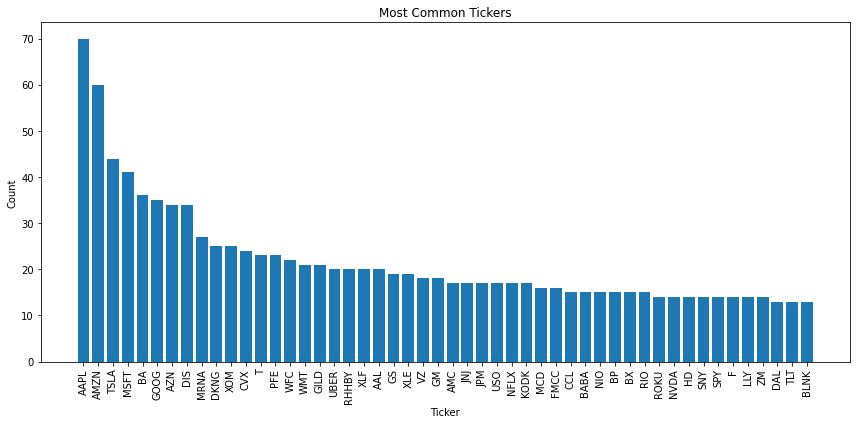

In [3]:
#How many different companies? 
unique_tickers=data['ticker'].unique() #get unique tickers (company names)
print("There are ", len(unique_tickers), " unique tickers.")
ticker_counts=data['ticker'].value_counts()
print("The most common tickers featured are: \n")
for ticker, count in ticker_counts.items(): 
    print(f"{ticker}: {count}")

#visualize
ticker_counts=data['ticker'].value_counts().head(50)
plt.figure(figsize=(12,6))
plt.bar(ticker_counts.index,ticker_counts.values)
plt.title('Most Common Tickers')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Pretty standard distribution, as expected large companies (Apple, Amazon, Tesla, MIcrosoft...) are mentioned quite often.

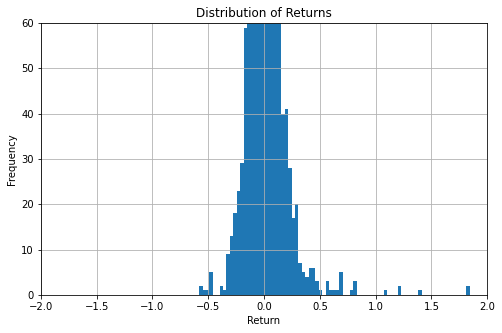

In [268]:
#Overall returns distribution
plt.figure(figsize=(8,5))
plt.hist(data['return'],bins=10000)
plt.xlim(-2,2)
plt.ylim(0,60)
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
#Seems to be centered around 0 (as expected, no bias involved)
#Doesn't seem to be many large outliers 

Looks like the returns are (for the most part) well centered around 0, as expected. This implies there is no huge positive or negative bias, which is great for our problem that involves using words to figure out what direction the stock might go. There also doesn't seem to be too many large outliers, although there a certainly a few (especially on the positive side of the returns) that will need to be removed before modeling.

In [4]:
#double check for large outliers
print(data['return'].describe())
#maximum value is highly suspicious, investigate 
max_return=data['return'].max()
max_return_row=data[data['return']==max_return]

print("\nMaximum return value row: ", max_return_row) #clearly, this return is basically impossible, likely will need to remove it
#check for more outliers

outliers = data[abs(data['return']) > 5] #check for outliers representing more than %500 change
print(f"\nNumber of return outliers > 5 or < -5: {len(outliers)}")
print(outliers)

mean=data['return'].mean()
std=data['return'].std()
z_threshold=3 

outliers_z=data[(data['return']-mean).abs()>z_threshold*std] #check outliers using z-scores
print(f"\nNumber of outliers beyond {z_threshold} standard deviations: {len(outliers_z)}")
print(outliers_z)

print("\nLooks like the maximum value is WAY beyond the rest of the data, and all other return values are within -5 and 5, or within 3 standard deviations of the mean. Let's remove it.")
data=data[data['return'] != max_return] #remove this huge outlier
print("Max return after removal: ", data['return'].max())

count    10583.000000
mean         0.032623
std          2.977422
min         -0.581818
25%         -0.019319
50%          0.000000
75%          0.019744
max        306.142863
Name: return, dtype: float64

Maximum return value row:                                           Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  
7736  2020-07-31 07:35:00  306.142863  

Number of return outliers > 5 or < -5: 1
                                         Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  
7736  2020-07-31 07:35:00  306.142863  

Number of outliers beyond 3 standard deviations: 1
                                         Headlines ticker  \
7736   Banco de Sabadell, S.A. reports 1H results   BNDSF   

                     date      return  
7736  2020-07-31 07:35:00  306.142863  

Looks like the maximum value is WAY beyond the rest of the data

We removed all outliers beyond an absolute value of 5 or outside of 3 standard deviations from the mean. It is possible that some of these "outliers" are not errors, who knows? But for the sake of our work, we want to work with data that represents the normal reactions of the market to financial headlines. In order to do that we want to remove edge cases that may be anomalies. 

In [5]:
#Convert target (return) to classification (up/down)
data['direction']=data['return'].apply(lambda x: 1 if x > 0 else 0)
data.to_csv('headlines_with_returns_directions.csv')
data.head()

,Headlines,ticker,date,return,direction
0,CytoDyn to update investors on regulatory and...,CYDY,2020-08-28 04:46:00,-0.023256,0
1,Apple terminates Epic Games' developer account,AAPL,2020-08-28 04:41:00,0.033912,1
3,"Legend Biotech EPS misses by $0.42, misses on...",LEGN,2020-08-28 04:38:00,0.000000,0
4,Denmark's AAA rating affirmed by S&P as fisca...,EDEN,2020-08-28 04:37:00,0.000596,1
6,BNY Mellon Strategic Municipals declares $0.0...,LEO,2020-08-28 04:27:00,0.008516,1


Here we simply added a new "direction" feature, which is 0 if the stock went down (or stayed the same) and 1 if the stock went up. Pretty much just a classification of the direction of the stock's movement. 


Number of rows with return > 0:  4987

Number of rows with return exactly equal 0:  463

Number of rows with return < 0:  5132


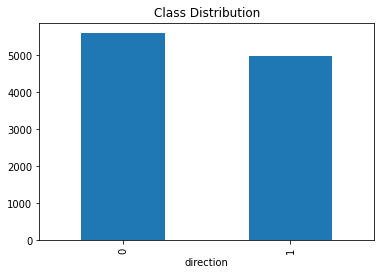

In [6]:
#Getting a general idea of directions
data['direction'].value_counts().plot(kind='bar',title='Class Distribution')
print('\nNumber of rows with return > 0: ', (data['return']>0).sum())
print('\nNumber of rows with return exactly equal 0: ', (data['return']==0).sum())
print('\nNumber of rows with return < 0: ', (data['return']<0).sum())

Above we made sure that the two directions have a largely even amount of rows, which they do. We'll note that it may appear that there are far more going in the negative direction than positive, however we recall that all the rows that had no net change in their stock value are assigned 0.

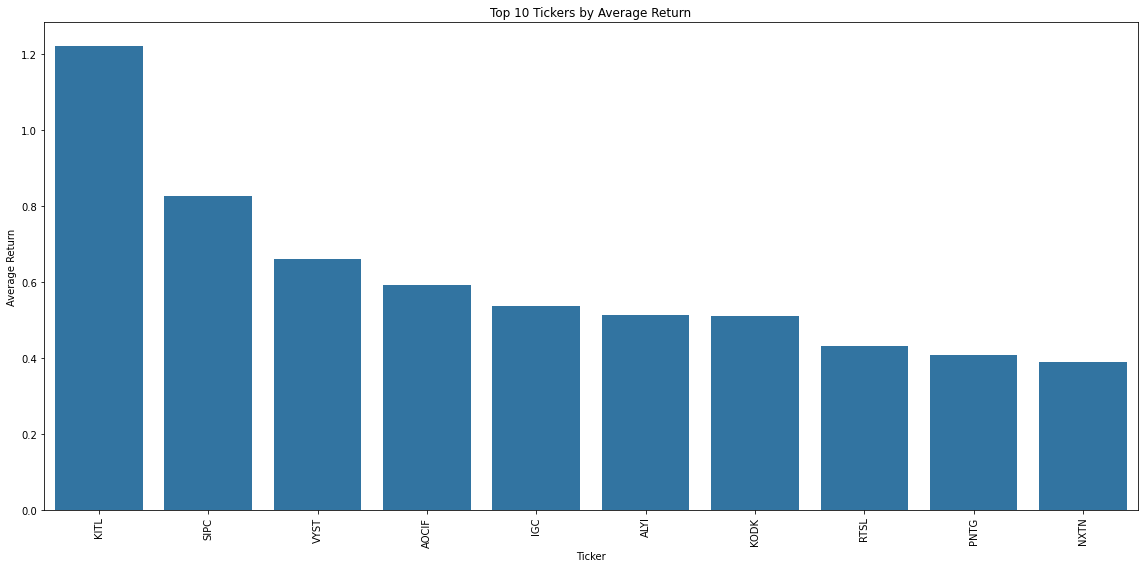

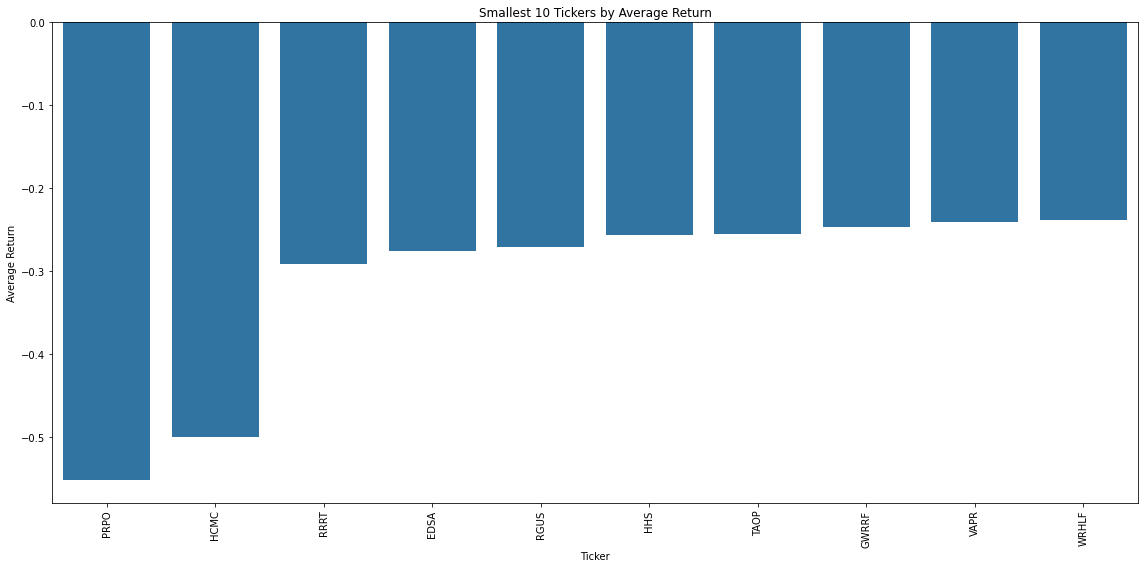

In [7]:
#Average returns per ticker
avg_return_per_ticker=data.groupby(['ticker'])['return'].mean()
avg_return_per_ticker=avg_return_per_ticker.sort_values(ascending=False)
top100avgperticker=avg_return_per_ticker.head(10)
avg_return_per_tickerdesc=avg_return_per_ticker.sort_values(ascending=True)
top100avgpertickerdesc=avg_return_per_tickerdesc.head(10)

plt.figure(figsize=(16, 8))
sns.barplot(x=top100avgperticker.index,y=top100avgperticker.values)
plt.xticks(rotation=90)
plt.title('Top 10 Tickers by Average Return')
plt.xlabel('Ticker')
plt.ylabel('Average Return')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(x=top100avgpertickerdesc.index,y=top100avgpertickerdesc.values)
plt.xticks(rotation=90)
plt.title('Smallest 10 Tickers by Average Return')
plt.xlabel('Ticker')
plt.ylabel('Average Return')
plt.tight_layout()
plt.show()



Not too much to say here, just verifying that there aren't some couple tickers that are huge outliers compared to the others. Wouldn't want to include a company that has its stock values changing wildly compared to the other companies for the sake of our problem. 

In [8]:
#Average return per month
data['date']=pd.to_datetime(data['date'])
monthly_avg_return=data.set_index('date').groupby(pd.Grouper(freq='M'))['return'].mean().reset_index()
monthly_avg_return.head()

,date,return
0,2020-07-31,0.005332
1,2020-08-31,0.002208


Looking at average return per month in these two months of July and August. 

In [9]:
#Average return per day of the week
weekday_avg_return=data.groupby(data['date'].dt.day_name())['return'].mean().reset_index()
weekday_avg_return.head(12)

,date,return
0,Friday,0.006634
1,Monday,-0.004113
2,Saturday,-0.007736
3,Sunday,-0.002229
4,Thursday,0.003263
5,Tuesday,0.014929
6,Wednesday,-0.001834


Looking at average return per day of the week.

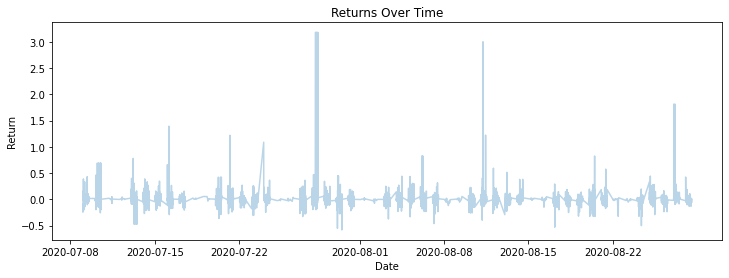

In [10]:
#return vs. date
data['date']=pd.to_datetime(data['date'])
data.sort_values('date',inplace=True)
plt.figure(figsize=(12, 4))
plt.plot(data['date'],data['return'],alpha=0.3)
plt.title('Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

Getting an overview of the returns over time for this period.

In [11]:
#what words are most common? 
def tokenize(text): #function to split text into lowercase word tokens
    return re.findall(r'\b\w+\b',text.lower())

all_words=data['Headlines'].dropna().apply(tokenize).sum() #flatten all tokens
word_counts=Counter(all_words)

#top 20 most common
common_words=word_counts.most_common(20)
print("The most common words are: ")
for word,count in common_words: 
    print(f"{word}: {count}")
    
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

all_words=data['Headlines'].dropna().apply(tokenize).sum() #flatten all tokens
filtered_words=[word for word in all_words if word not in stop_words]
word_counts=Counter(filtered_words)

#top 20 most common (without stop words)
common_words=word_counts.most_common(20)
print("\nThe most common words (excluding stop words) are: ")
for word,count in common_words: 
    print(f"{word}: {count}")


The most common words are: 
on: 3008
beats: 2902
0: 2600
by: 2166
revenue: 2131
eps: 1955
to: 1428
in: 1278
misses: 1135
q2: 1125
s: 1032
dividend: 922
for: 911
results: 814
reports: 799
declares: 746
of: 730
after: 696
and: 560
as: 516


[nltk_data] Downloading package stopwords to /Users/enzo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



The most common words (excluding stop words) are: 
beats: 2902
0: 2600
revenue: 2131
eps: 1955
misses: 1135
q2: 1125
dividend: 922
results: 814
reports: 799
declares: 746
new: 405
earnings: 401
19: 332
covid: 304
offering: 303
among: 287
1: 285
u: 257
financial: 232
energy: 231


Taking a look at the most common words in our headlines, and then taking a look again but removing stop words (as defined by nltk library). This poses the question: should we remove stop words before modeling? It might improve performance by reducing the dimensionality of our data, however some stop words are actually important: negations, modal verbs, comparitive words, and finance-specific directional words can all carry meaning in the context of affecting stock movement or sentiment... We would probably have to come up with a custom group of stop-words to remove if we went this path.

In [12]:
#save data
data.to_csv('headlinesNLPdata.csv')